# PREDICTIONS

## Loading Data

In [6]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score, f1_score, log_loss, classification_report, confusion_matrix

import xgboost as xgb

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

import sys
from pathlib import Path

utils_path = Path("../../Code/0.Utils").resolve()
sys.path.append(str(utils_path))
from utils import COLS_TO_EXCLUDE

df = pd.read_csv('../../Datasets/final_tennis_dataset_symmetric.csv')

In [ ]:

# 1) Load the dataset and extract the tournament year
df['TOURNEY_DATE'] = df['TOURNEY_DATE'].astype(str)
df['year'] = df['TOURNEY_DATE'].str[:4].astype(int)

# 2) Define target and drop leakage/raw columns
y = df['TARGET']
X = df.drop(columns=COLS_TO_EXCLUDE, errors='ignore')
X = X.select_dtypes(include=[np.number])

# 3) Split by year: train ≤2023, test = 2024
train_mask = df['year'] <= 2023
test_mask  = df['year'] == 2024
X_train, y_train = X[train_mask], y[train_mask]
X_test,  y_test  = X[test_mask],  y[test_mask]

# 4) Common imports for metrics and plotting
from sklearn.metrics import (
    accuracy_score, f1_score, log_loss,
    classification_report, confusion_matrix
)
from sklearn.tree import plot_tree

def evaluate_model(model, name):
    """
    Fit the model, print metrics, plot confusion matrix
    with counts+percentages, show top-20 importances,
    and draw the first 3 levels if it's a single DecisionTree.
    """
    # Train and predict
    model.fit(X_train, y_train)
    y_pred  = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    # Compute scores
    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred)
    ll  = log_loss(y_test, y_proba)
    print(f"\n{name} Results on 2024 test set")
    print(f"  Accuracy : {acc:.4f}")
    print(f"  F1 Score : {f1:.4f}")
    print(f"  Log Loss : {ll:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix with counts & percentages
    cm = confusion_matrix(y_test, y_pred)
    total = cm.sum()

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    norm = im.norm
    fig.colorbar(im, ax=ax)

    ax.set_title(f"{name} Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])

    # annotate every cell with count + %
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count = cm[i,j]
            pct   = 100 * count / total if total else 0
            # choose white/black by normalized intensity
            color = 'white' if norm(count) > 0.5 else 'black'
            ax.text(j, i,
                    f"{count}\n{pct:.1f}%",
                    ha='center', va='center',
                    color=color,
                    fontsize=12)

    plt.show()

    # Top-20 feature importances
    importances = model.feature_importances_
    idxs = np.argsort(importances)[::-1][:20]
    fig, ax = plt.subplots()
    ax.bar(range(len(idxs)), importances[idxs])
    ax.set_xticks(range(len(idxs)))
    ax.set_xticklabels([X_train.columns[i] for i in idxs], rotation=45, ha='right')
    ax.set_title(f"{name} Top 20 Feature Importances")
    plt.tight_layout()
    plt.show()

    # If it's a single DecisionTree, plot its first 3 levels
    if hasattr(model, "tree_"):
        fig, ax = plt.subplots(figsize=(18,10))
        plot_tree(
            model,
            max_depth=3,
            feature_names=X_train.columns,
            class_names=["0","1"],
            filled=True,
            rounded=True,
            impurity=False,
            ax=ax
        )
        ax.set_title(f"{name} Tree Structure (depth=3)")
        plt.show()

## DECISION TREE


Decision Tree Results on 2024 test set
  Accuracy : 0.6405
  F1 Score : 0.6418
  Log Loss : 0.6232

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.64      0.64      2761
           1       0.64      0.64      0.64      2761

    accuracy                           0.64      5522
   macro avg       0.64      0.64      0.64      5522
weighted avg       0.64      0.64      0.64      5522



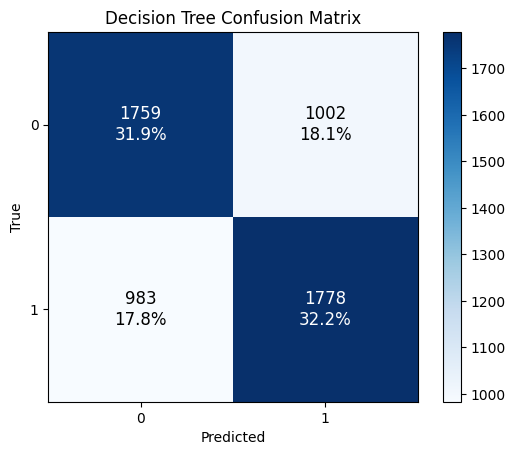

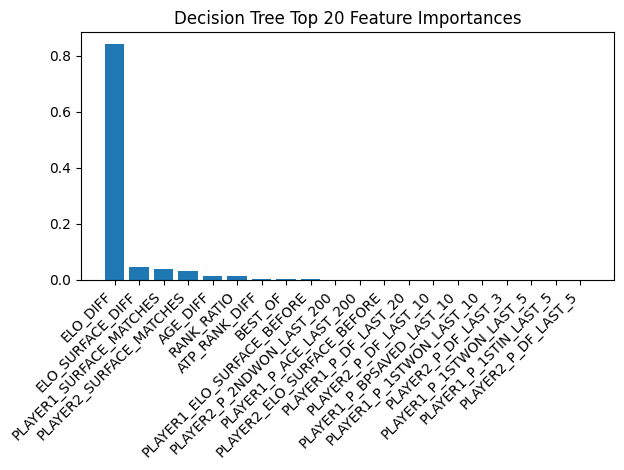

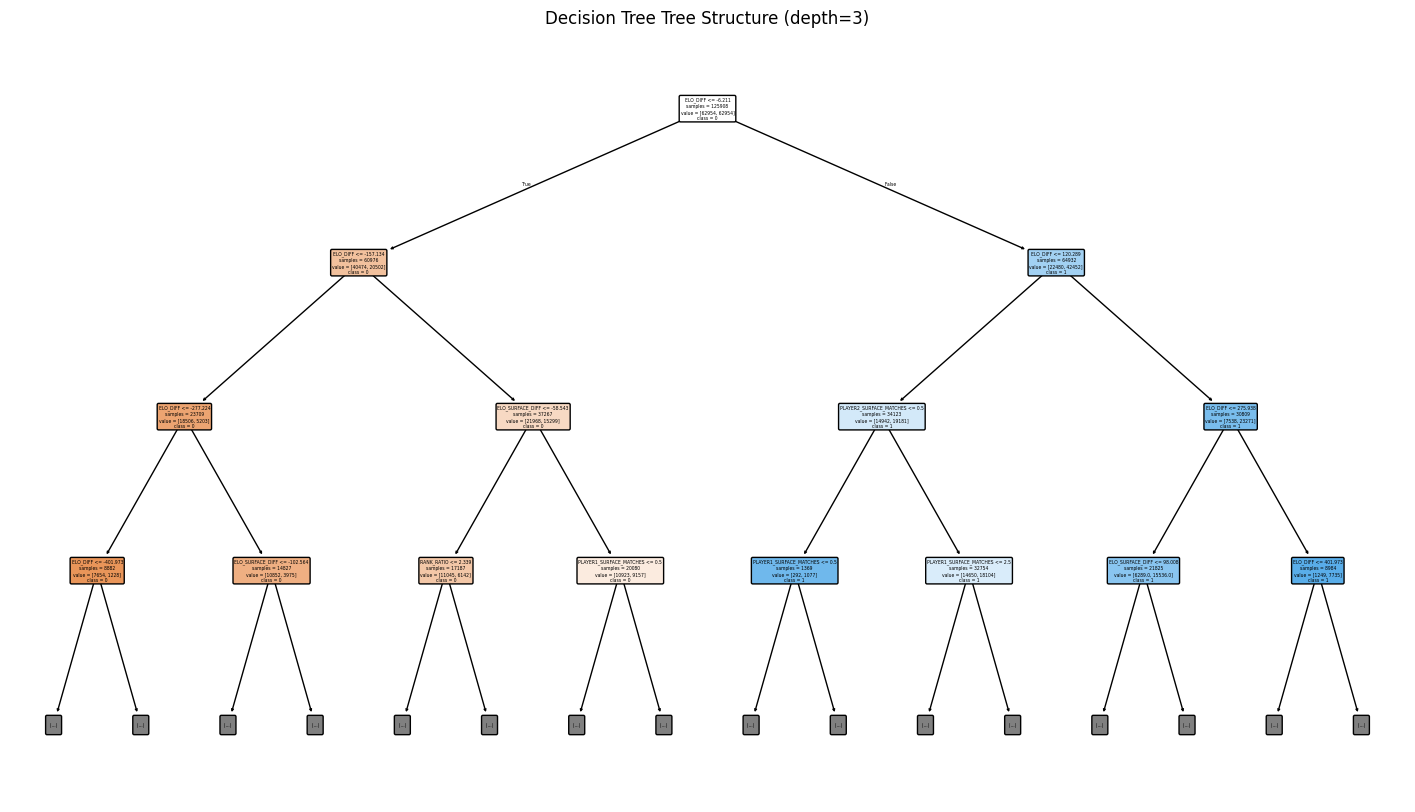

In [8]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(
    criterion='gini',
    max_depth=6,
    min_samples_split=50,
    random_state=42
)
evaluate_model(dt, "Decision Tree")

In [9]:
dump(dt, "../../Models/decision_tree.joblib")
print("Decision tree saved to ./Models/decision_tree.joblib")

dt_loaded = load("../../Models/decision_tree.joblib")

Decision tree saved to ./Models/decision_tree.joblib


## RANDOM FOREST


Random Forest Results on 2024 test set
  Accuracy : 0.6490
  F1 Score : 0.6487
  Log Loss : 0.6172

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.65      0.65      2761
           1       0.65      0.65      0.65      2761

    accuracy                           0.65      5522
   macro avg       0.65      0.65      0.65      5522
weighted avg       0.65      0.65      0.65      5522



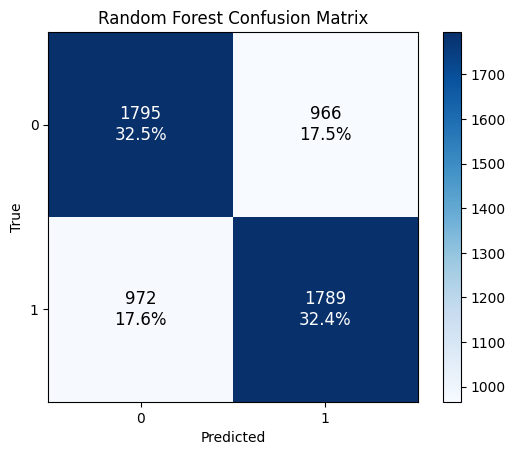

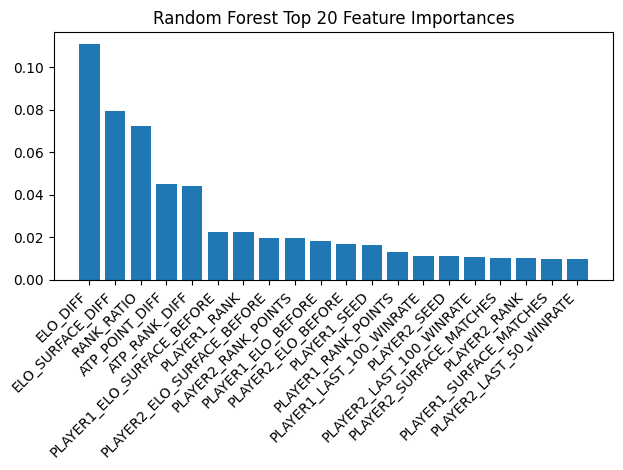

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=12,
    min_samples_split=30,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # utile si léger déséquilibre
)
evaluate_model(rf, "Random Forest")

In [11]:
dump(rf, "../../Models/random_forest.joblib")
print("Random forest saved to ./Models/random_forest.joblib")

rf_loaded = load("../../Models/random_forest.joblib")

Random forest saved to ./Models/random_forest.joblib


## Random forest with CV


=== Random Forest 5-Fold Cross-Validation (on train set) ===
accuracy     — train: 0.7409 ± 0.0012 | test: 0.6727 ± 0.0021
f1           — train: 0.7407 ± 0.0015 | test: 0.6724 ± 0.0028
log_loss     — train: 0.5311 ± 0.0006 | test: 0.5985 ± 0.0013

Random Forest Results on 2024 test set
  Accuracy : 0.6490
  F1 Score : 0.6487
  Log Loss : 0.6172

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.65      0.65      2761
           1       0.65      0.65      0.65      2761

    accuracy                           0.65      5522
   macro avg       0.65      0.65      0.65      5522
weighted avg       0.65      0.65      0.65      5522



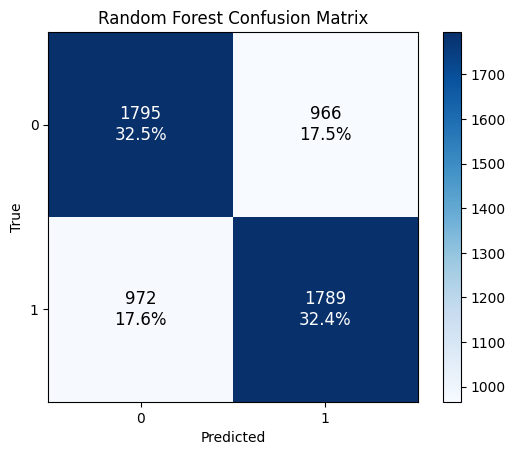

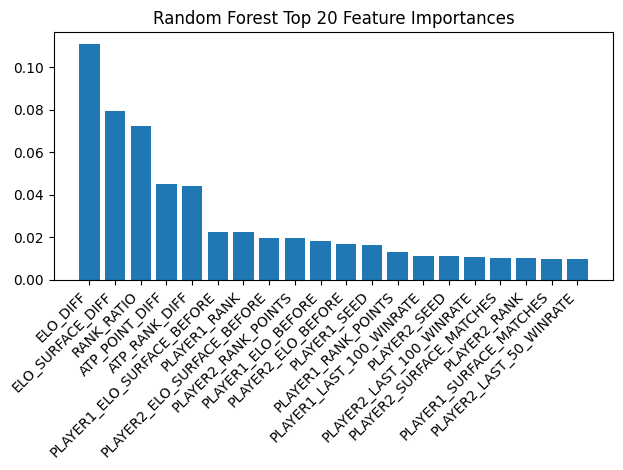

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate

# 1) Instantiate your RF with the same hyper‐parameters you plan to use
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=12,
    min_samples_split=30,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

# 2) Set up a 5-fold stratified splitter
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 3) Define the metrics you want to compute
scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1',
    'neg_log_loss': 'neg_log_loss'
}

# 4) Run cross‐validation on your TRAINING set only
cv_results = cross_validate(
    rf,
    X_train, y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1
)

# 5) Summarize CV results
print("\n=== Random Forest 5-Fold Cross-Validation (on train set) ===")
for metric in ['accuracy', 'f1', 'neg_log_loss']:
    train_scores = cv_results[f'train_{metric}']
    test_scores  = cv_results[f'test_{metric}']
    # for log_loss we invert back to positive
    if metric == 'neg_log_loss':
        train_scores = -train_scores
        test_scores  = -test_scores
        metric_name = 'log_loss'
    else:
        metric_name = metric
    print(f"{metric_name:12s} — train: {train_scores.mean():.4f} ± {train_scores.std():.4f} "
          f"| test: {test_scores.mean():.4f} ± {test_scores.std():.4f}")

# 6) Finally, train on all of X_train/y_train and evaluate on your hold‐out 2024 set
evaluate_model(rf, "Random Forest")


## XGBoost

/mnt/netapp2/Store_uni/home/ulc/cursos/curso363/mypython/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:17:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Results on 2024 test set
  Accuracy : 0.6603
  F1 Score : 0.6615
  Log Loss : 0.6057

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.66      0.66      2761
           1       0.66      0.66      0.66      2761

    accuracy                           0.66      5522
   macro avg       0.66      0.66      0.66      5522
weighted avg       0.66      0.66      0.66      5522



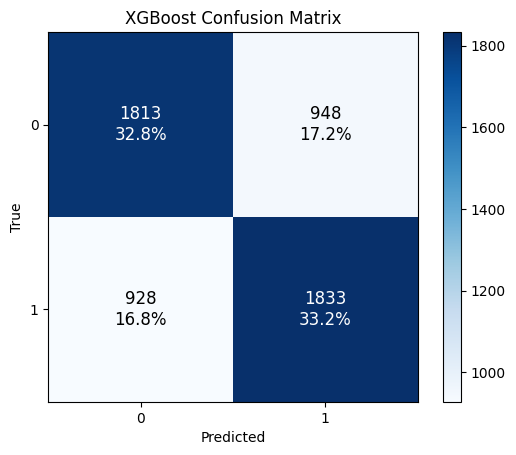

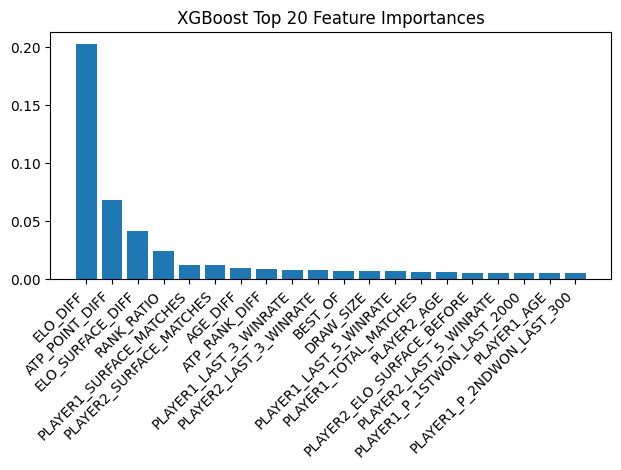

In [13]:
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

evaluate_model(xgb_model, "XGBoost")

In [14]:
xgb_model.save_model("../../Models/xgb_model.json")

## Comparaison

In [16]:
import pandas as pd
import xgboost as xgb
from joblib import load
from sklearn.metrics import accuracy_score, f1_score, log_loss

# 1) Load the saved models
dt  = load("../../Models/decision_tree.joblib")
rf  = load("../../Models/random_forest.joblib")
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.load_model("../../Models/xgb_model.json")

models = {
    "Decision Tree": dt,
    "Random Forest": rf,
    "XGBoost":       xgb_model
}

# 2) (Re)use your existing test split
#    Make sure you have X_test, y_test already defined.

# 3) Compute metrics for each model
results = []
for name, model in models.items():
    y_pred  = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    results.append({
        "Model":    name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "Log Loss": log_loss(y_test, y_proba)
    })

# 4) Build and print a simple table
df_comparison = (
    pd.DataFrame(results)
      .set_index("Model")
      .round({"Accuracy":4, "F1 Score":4, "Log Loss":4})
)
print(df_comparison)

               Accuracy  F1 Score  Log Loss
Model                                      
Decision Tree    0.6405    0.6418    0.6232
Random Forest    0.6490    0.6487    0.6172
XGBoost          0.6603    0.6615    0.6057


| Model          | Accuracy | F1 Score | Log Loss |
| -------------- | -------- | -------- | -------- |
| Decision Tree  | 0.6405   | 0.6418   | 0.6232   |
| Random Forest  | 0.6490   | 0.6487   | 0.6172   |
| XGBoost        | 0.6603   | 0.6615   | 0.6057   |

# Metric Definitions

## 1. Accuracy

**Meaning**  
Proportion of correct predictions (true positives and true negatives) among all instances.

$$
\mathrm{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

Where:  
- $TP$: number of true positives  
- $TN$: number of true negatives  
- $FP$: number of false positives  
- $FN$: number of false negatives  

---

## 2. $F_{1}$-Score

**Meaning**  
Harmonic mean of precision and recall; useful when classes are imbalanced.

**Precision**  
$$
\mathrm{Precision} = \frac{TP}{TP + FP}
$$

**Recall**  
$$
\mathrm{Recall} = \frac{TP}{TP + FN}
$$

**$F_{1}$-Score**  
$$
F_{1} = 2 \times \frac{\mathrm{Precision}\,\times\,\mathrm{Recall}}{\mathrm{Precision} + \mathrm{Recall}}
$$

---

## 3. Log Loss (Binary Cross-Entropy)

**Meaning**  
Measures the distance between predicted probabilities and true labels; heavily penalizes confident but incorrect predictions.

$$
\mathrm{LogLoss} = -\frac{1}{N}\sum_{i=1}^{N}\Bigl[y_{i}\,\log(p_{i}) + (1 - y_{i})\,\log(1 - p_{i})\Bigr]
$$

Where:  
- $N$: total number of examples  
- $y_{i}\in\{0,1\}$: true class label of instance $i$  
- $p_{i}$: predicted probability of the positive class for instance $i$  
